In [1]:
#Importación de las librerías necesarias 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

Importing plotly failed. Interactive plots will not work.


In [2]:
'''Lectura de los datos, en este caso se utilizó la descarga de los datos del Sensor 33117 
directamente desde supabase hasta el 16 de julio a las 2:00 p.m.
El archivo fue modificado manualmente para eliminar las columnas innecesarias y para reordenar las dos columnas presentadas,
Es importante que la primera columna sean las fechas y la segunda la concentración de pm 2.5'''
pjme = pd.read_csv('Sensor_33117.csv',dayfirst=True,
                   index_col=[0], parse_dates=[0]) # We set the index column to the dates 


In [3]:
pjme

,pm25
time_stamp,
2023-07-19 12:01:00,29.9
2023-07-19 13:00:00,29.0
2023-07-19 14:01:00,24.0
2023-07-19 15:04:00,19.7
2023-07-19 16:04:00,16.1
...,...
2024-07-16 10:00:00,35.8
2024-07-16 11:00:00,39.1
2024-07-16 12:00:00,41.1


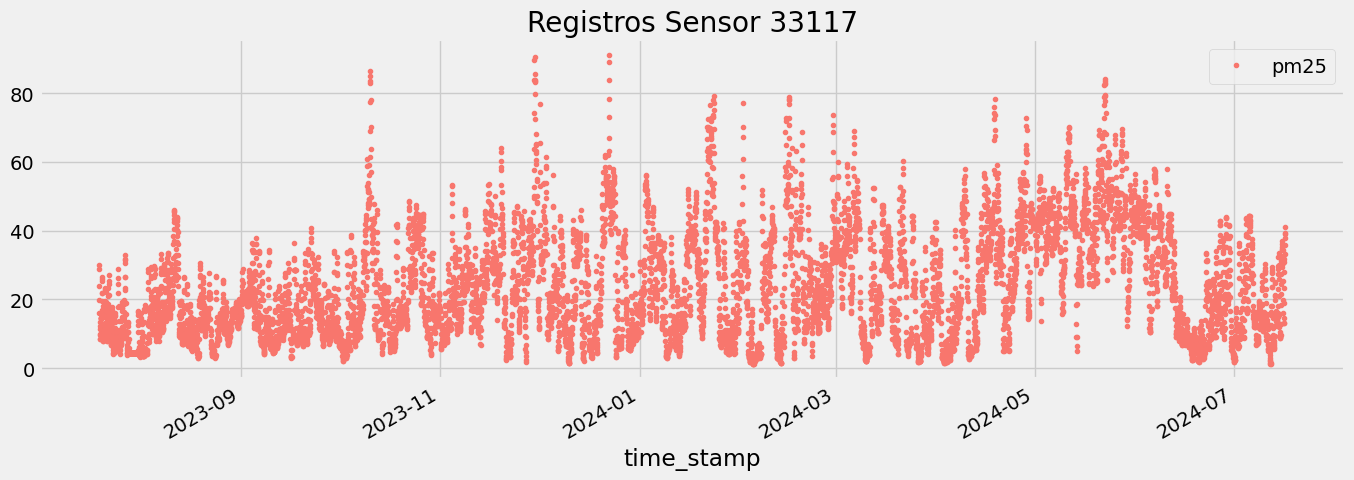

In [4]:
#Visualización de los datos
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='Registros Sensor 33117')
plt.show()

In [5]:
#Creación de un formato exploratorio para la serie de tiempo
def create_features(df, label=None):
    """
    Creates time series features from time_stamp index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='pm25')

features_and_target = pd.concat([X, y], axis=1)

In [6]:
# See our features and target
features_and_target.tail()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,pm25
time_stamp,,,,,,,,,
2024-07-16 10:00:00,10,1,3,7,2024,198,16,29,35.8
2024-07-16 11:00:00,11,1,3,7,2024,198,16,29,39.1
2024-07-16 12:00:00,12,1,3,7,2024,198,16,29,41.1
2024-07-16 13:01:00,13,1,3,7,2024,198,16,29,39.4
2024-07-16 14:00:00,14,1,3,7,2024,198,16,29,38.0


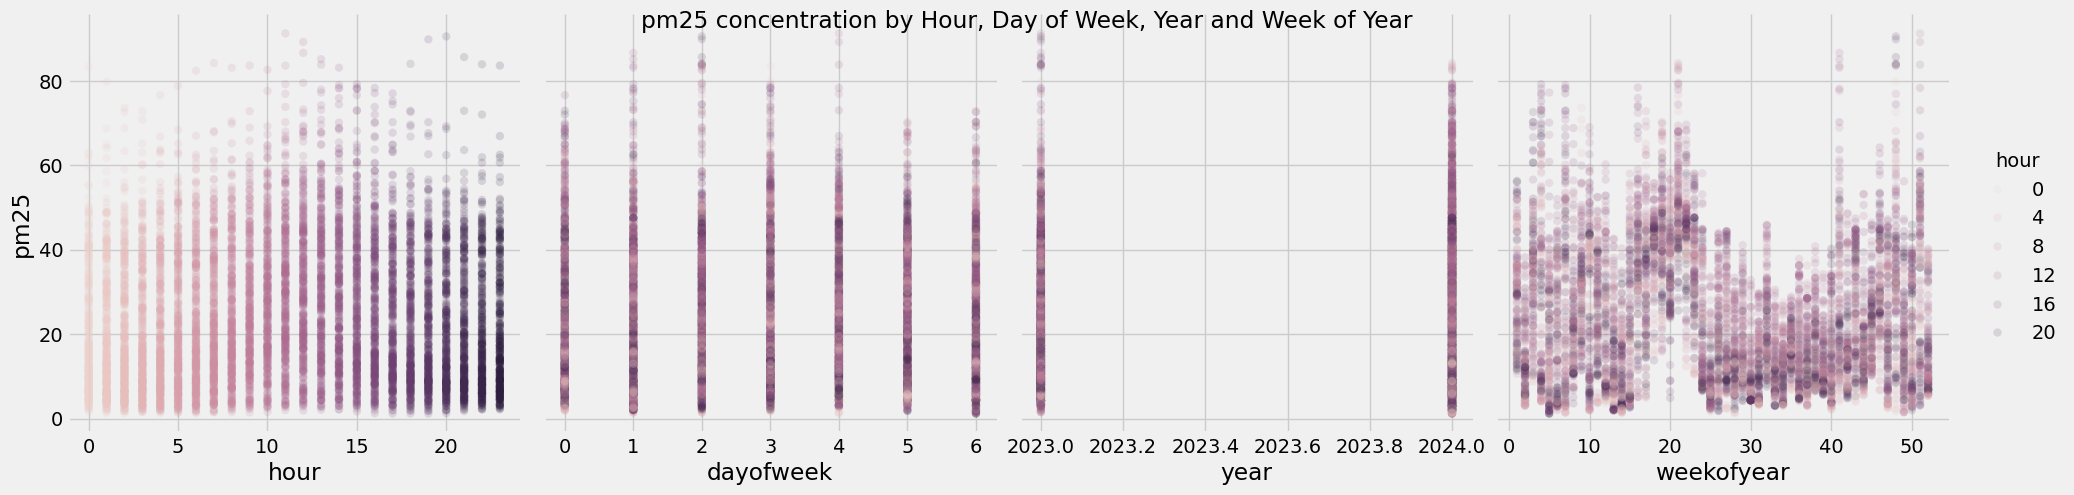

In [7]:
#Visualización de los datos 
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='pm25',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('pm25 concentration by Hour, Day of Week, Year and Week of Year')
plt.show()

In [8]:
#Se define la cantidad de datos de entrenamiento y testeo
split_date = '01-Jul-2024'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

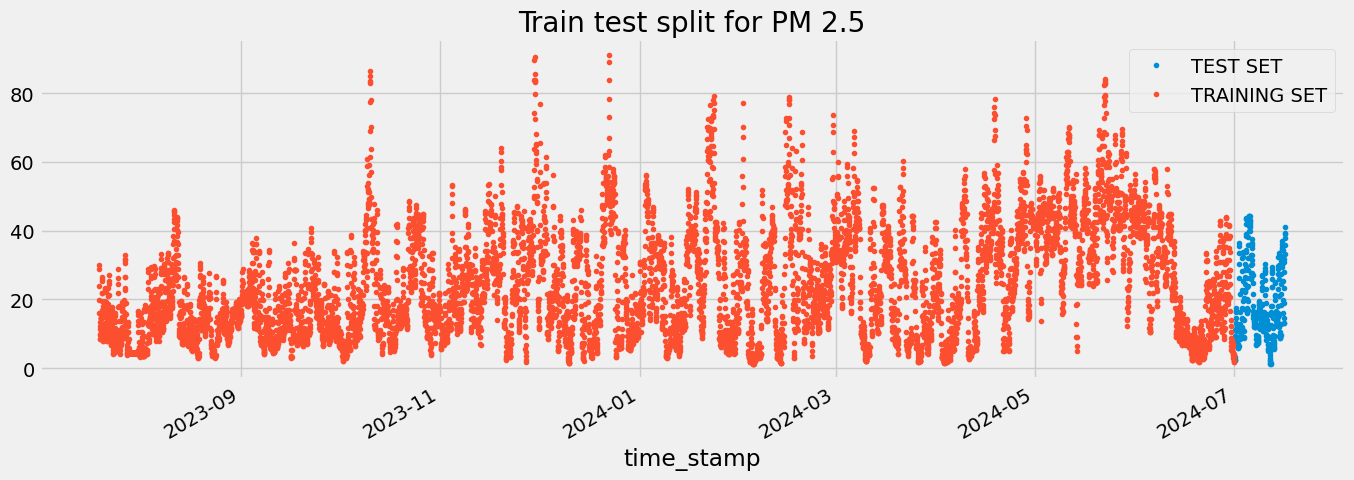

In [9]:
# Grafico de la división de datos en entrenamiento y testeo
pjme_test \
    .rename(columns={'pm25': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'pm25': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Train test split for PM 2.5', style='.')
plt.show()

In [10]:
# Formateo de los datos al formato especificado por la librería de Prophet
pjme_train.reset_index() \
    .rename(columns={'time_stamp':'ds',
                     'pm25':'y'}).head()

,ds,y
0,2023-07-19 12:01:00,29.9
1,2023-07-19 13:00:00,29.0
2,2023-07-19 14:01:00,24.0
3,2023-07-19 15:04:00,19.7
4,2023-07-19 16:04:00,16.1


Facebook Prophet es una librería de código abierto desarrollada por Facebook para la predicción de series temporales univariadas. Está diseñada para ser fácil de usar y automatizar el proceso de ajuste de hiperparámetros, lo que la hace accesible incluso para usuarios sin experiencia en estadística.
*
Características principale*s* :
Modelo aditivo: Prophet utiliza un modelo aditivo que permite ajustar tendencias no lineales con estacionalidades anuales, semanales y diarias, además de efectos de días festios* 1.
Automatización: La librería está diseñada para ser completamente automática. Solo necesitas proporcionar una serie temporal y Prophet se encarga del rsarn2.

In [ ]:
# Primera iteracción del modelo: Únicamente se modifica 'seasonality de manera arbitraria'

In [12]:
# Setup and train model and fit
m= Prophet(yearly_seasonality=0.01)
forecast=m.fit(pjme_train.reset_index() \
              .rename(columns={'time_stamp':'ds',
                               'pm25':'y'})).predict(df=pjme_test.reset_index() \
                                   .rename(columns={'time_stamp':'ds'}))

23:02:08 - cmdstanpy - INFO - Chain [1] start processing
23:02:09 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
#Segunda iteración del moelo: Se usa la función que determina cambios en la tendencia. Este modelo fue capaz de predecir valores 
#de "Mala" calidad en el aire

23:02:11 - cmdstanpy - INFO - Chain [1] start processing
23:02:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


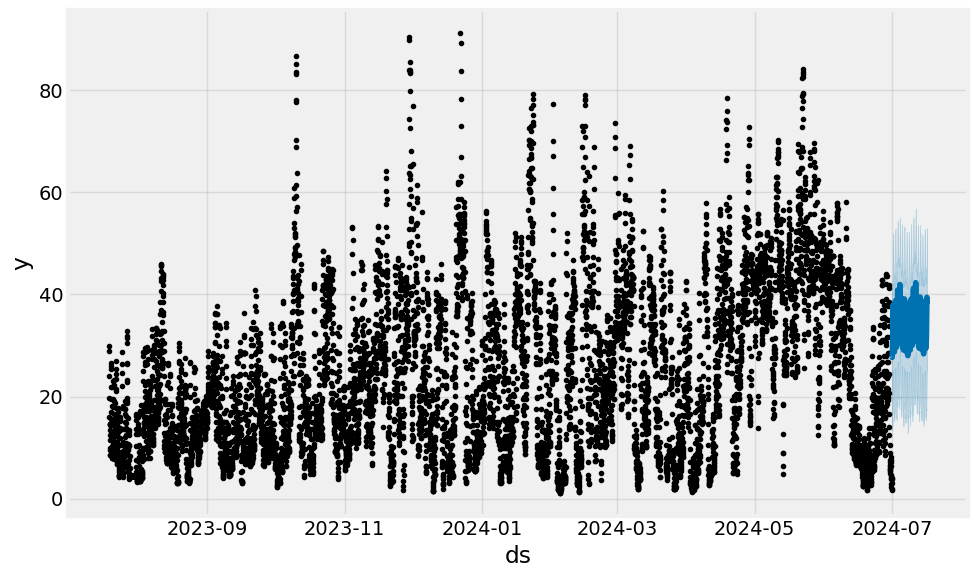

In [14]:
# Entrenamiento y gráfico del modelo 
m= Prophet(changepoint_prior_scale=0.001, interval_width=0.65)
forecast=m.fit(pjme_train.reset_index() \
              .rename(columns={'time_stamp':'ds',
                               'pm25':'y'})).predict(df=pjme_test.reset_index() \
                                   .rename(columns={'time_stamp':'ds'}))
fig = m.plot(forecast)

In [15]:
#Visualización de la información entregada por el modelo
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-07-01 00:07:00,32.802033,14.924973,42.134367,32.802033,32.802033,-5.069417,-5.069417,-5.069417,-3.287814,-3.287814,-3.287814,-1.781603,-1.781603,-1.781603,0.0,0.0,0.0,27.732616
1,2024-07-01 01:01:00,32.803915,14.503481,42.578786,32.803915,32.803915,-5.138643,-5.138643,-5.138643,-3.375318,-3.375318,-3.375318,-1.763325,-1.763325,-1.763325,0.0,0.0,0.0,27.665272
2,2024-07-01 02:01:00,32.806005,13.388304,40.926798,32.806005,32.806005,-5.046927,-5.046927,-5.046927,-3.309064,-3.309064,-3.309064,-1.737862,-1.737862,-1.737862,0.0,0.0,0.0,27.759078
3,2024-07-01 03:00:00,32.808061,15.071762,41.639501,32.808061,32.808061,-4.734825,-4.734825,-4.734825,-3.026927,-3.026927,-3.026927,-1.707898,-1.707898,-1.707898,0.0,0.0,0.0,28.073236
4,2024-07-01 04:00:00,32.810151,15.949151,41.534907,32.810151,32.810151,-4.266873,-4.266873,-4.266873,-2.594028,-2.594028,-2.594028,-1.672845,-1.672845,-1.672845,0.0,0.0,0.0,28.543278


C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


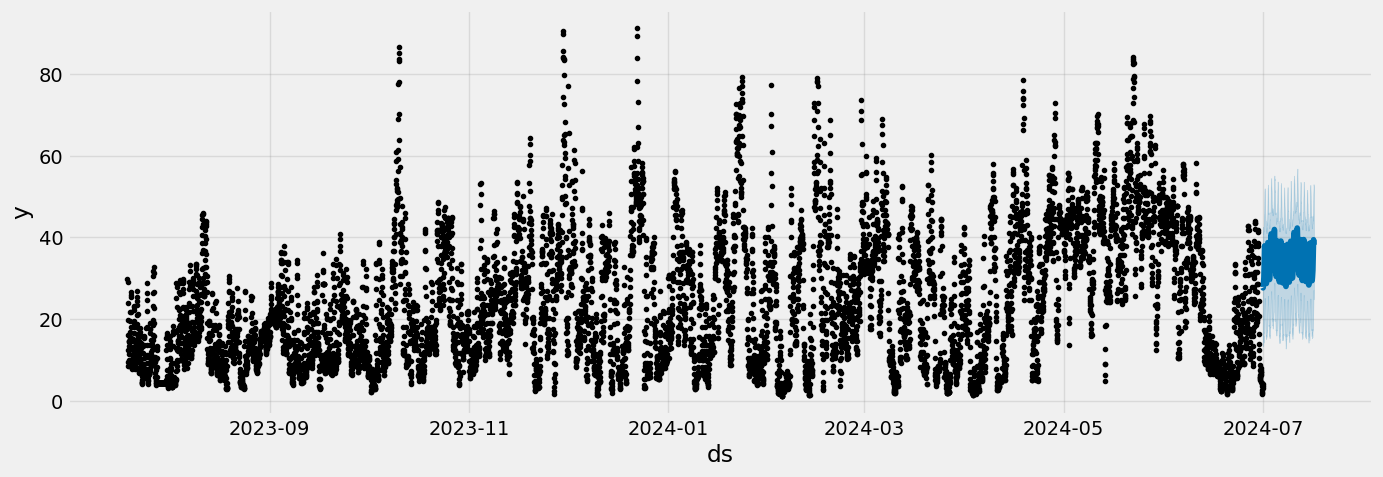

In [16]:
# Grafico con todos los datos históricos y los datos predichos 
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m.plot(forecast,
                 ax=ax)
plt.show()

C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarra

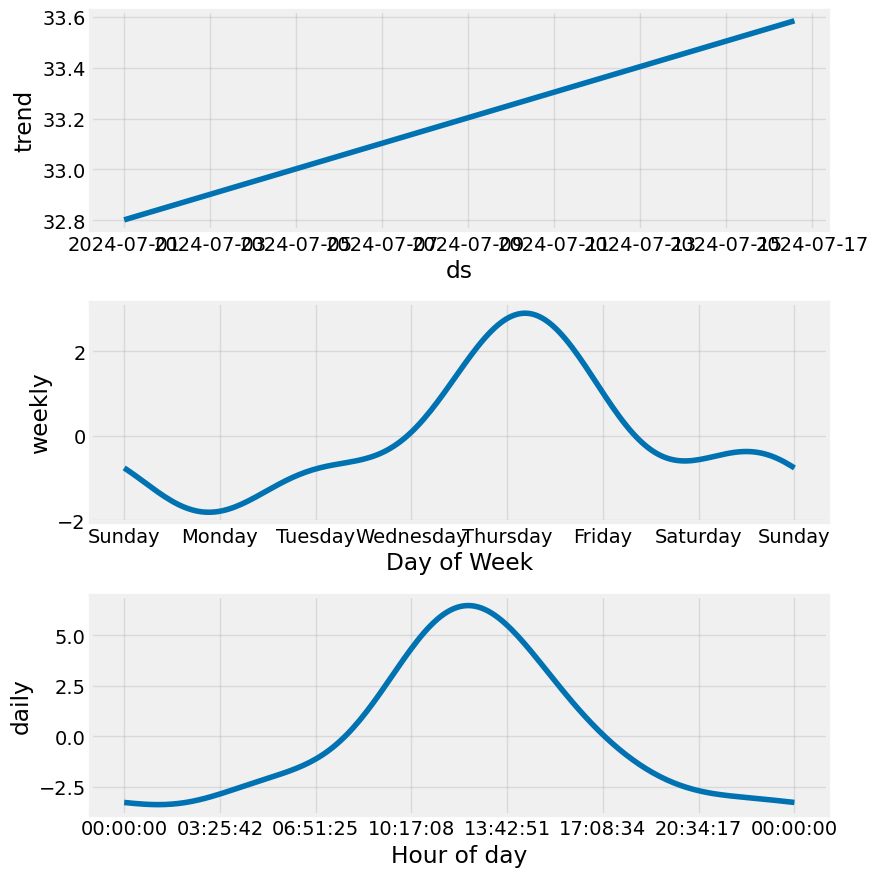

In [17]:
# Gráficos de los componentes del modelo: tendencias y distribuciones semanales y diarias de contaminantes
fig = m.plot_components(forecast)

C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


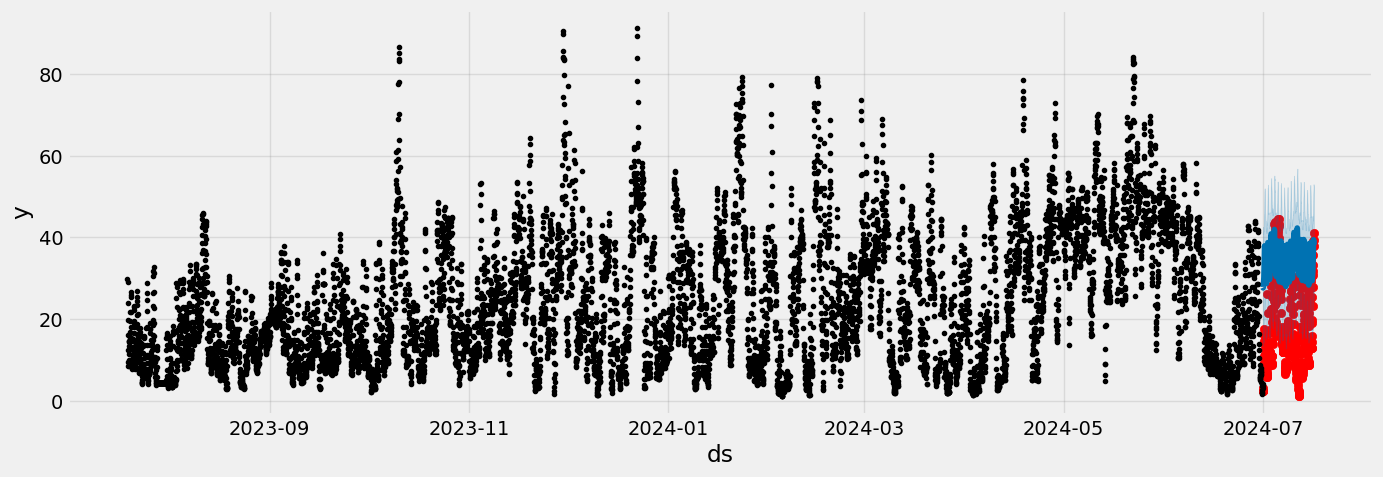

In [18]:
# Gráfica comparativa sobre el desempeño del modelo y los valores reales (testing phase) 
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['pm25'], color='r')
fig = m.plot(forecast, ax=ax)

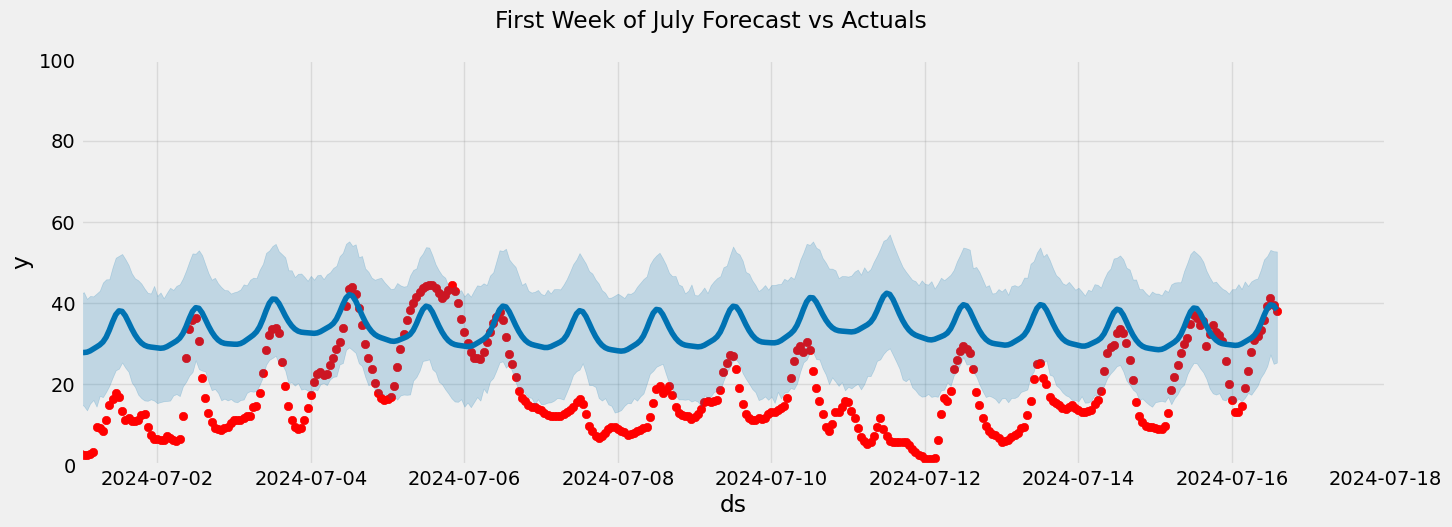

In [19]:
# Grafico comparativo del desempeño del modelo durante las fechas especificadas (en este caso durante 17 días)
start_date = pd.to_datetime('2024-07-01')
end_date = pd.to_datetime('2024-07-18')

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['pm25'], color='r')
fig = m.plot(forecast, ax=ax)

# Set the x-axis limits
ax.set_xlim(start_date, end_date)
ax.set_ylim(0, 100)
plt.suptitle('First Week of July Forecast vs Actuals')

plt.show()

In [20]:
#Error medio cuadrado 
mean_squared_error(y_true=pjme_test['pm25'],
                   y_pred=forecast['yhat'])

308.1236323197549

In [21]:
#Error medio absoluto
mean_absolute_error(y_true=pjme_test['pm25'],
                   y_pred=forecast['yhat'])

15.637826857570447

In [22]:
#Error medio absoluto porcentual
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['pm25'],
                   y_pred=forecast['yhat'])

178.38432496221208

In [23]:
# Chunk utilizado para la extracción de los datos al archivo de sheets: Descarga el pronóstico arrojado en la fase de testeo
#selected_columns = forecast[['ds', 'yhat']]
#selected_columns.to_csv('FB_prophet_forecast0107-01.csv', index=False)

In [24]:
#Función utilizada para realizar predicciones reales a futuro 
def predict_future(m, start_date, end_date):
    # Crear un dataframe con las fechas futuras
    future_dates = pd.date_range(start=start_date, end=end_date, freq='h')
    future_df = pd.DataFrame({'ds': future_dates})
    
    # Realizar la predicción
    forecast = m.predict(future_df)
    
    return forecast

# Configurar y entrenar el modelo
m = Prophet(changepoint_prior_scale=0.001, interval_width=0.65)
m.fit(pjme_train.reset_index().rename(columns={'time_stamp': 'ds', 'pm25': 'y'}))

# Especificar las fechas de inicio y fin para la predicción
start_date = '2024-07-16 14:00:00'
end_date = '2024-07-23 00:00:00'

# Obtener la predicción
future_forecast = predict_future(m, start_date, end_date)
# Select the columns 'ds' and 'yhat'
selected_columns = future_forecast[['ds', 'yhat']]

# Export the selected columns to a CSV file
selected_columns.to_csv('FB_prophet_forecast0107-02.csv', index=False)

23:02:15 - cmdstanpy - INFO - Chain [1] start processing
23:02:16 - cmdstanpy - INFO - Chain [1] done processing


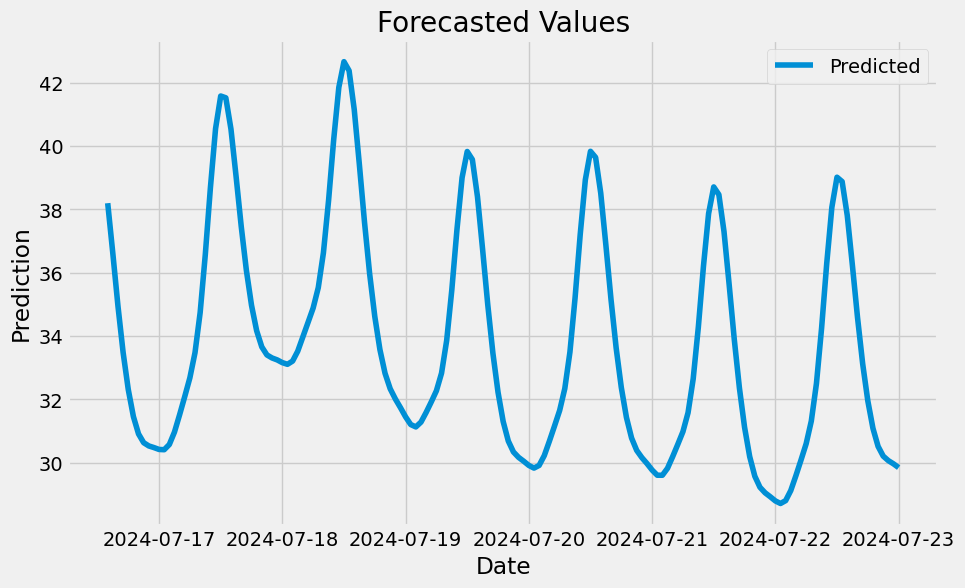

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(selected_columns['ds'], selected_columns['yhat'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Forecasted Values')
plt.legend()
plt.grid(True)
plt.show()